In [3]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

warnings.filterwarnings("ignore")

In [4]:
## loading train data using pandas library
train_df = pd.read_csv('data/train.csv', parse_dates = True, low_memory = False)

In [5]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [6]:
### Closed stores with no sales will not be counted for forcaset
df = train_df[(train_df.Open != 0) & (train_df.Sales != 0)]

df.drop(['Store','DayOfWeek','Customers','Open', 'Promo', 'StateHoliday', 'SchoolHoliday' ], axis=1, inplace=True)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Date' and sum the 'Sales' values for each unique date
sales_df = df.groupby('Date', as_index=False)['Sales'].sum()

# reverse to the order: from 2013 to 2015
sales_df = sales_df.sort_index(ascending = False)

# Set 'Date' column as the index
sales_df.set_index('Date', inplace=True)

In [7]:
sales_df.shape

(942, 1)

In [8]:
#pd.set_option('display.max_rows', None)
sales_df = sales_df.sort_index()
time_series = sales_df['2013-01-01':'2015-07-31'].resample('W').sum()
time_series#.head()

,Sales
Date,
2013-01-06,26129335
2013-01-13,49275222
2013-01-20,34377765
2013-01-27,46040169
2013-02-03,38466029
...,...
2015-07-05,55690481
2015-07-12,41391282
2015-07-19,52008419


# Visulization of the data

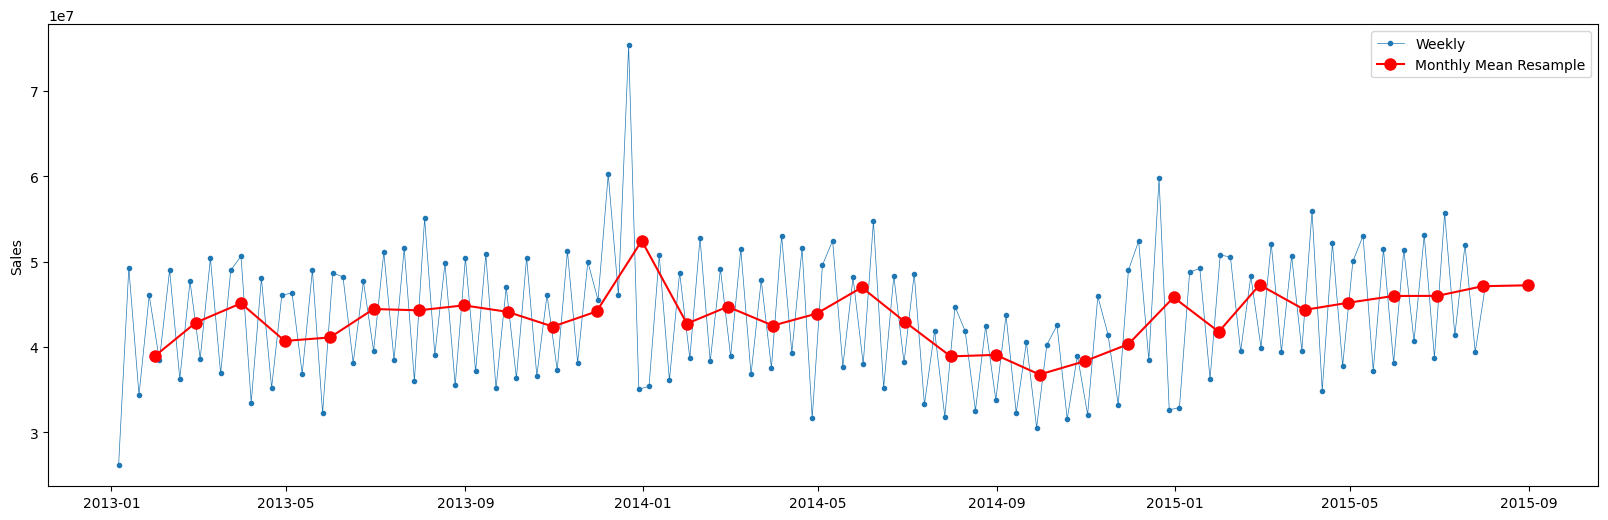

In [9]:
y = time_series['Sales'].copy()
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample', color='red')
ax.set_ylabel('Sales')
ax.legend();

## Time Series Analysis of Data
**Isolate the Rossmann Store Sales dataset into time series data**


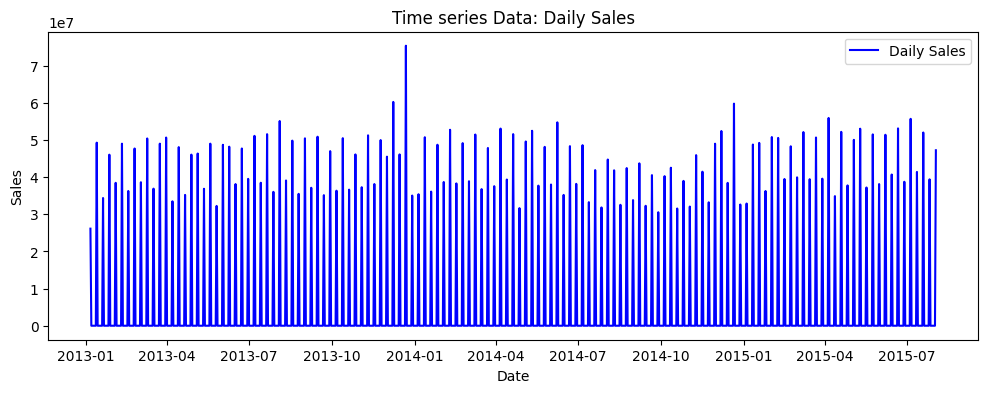

In [10]:
## Plotting the daily sales data
resample_df = y.resample('D').sum()
plt.figure(figsize=(12, 4))
plt.plot(resample_df, label='Daily Sales', color='blue')  # Set the color to blue
plt.title('Time series Data: Daily Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

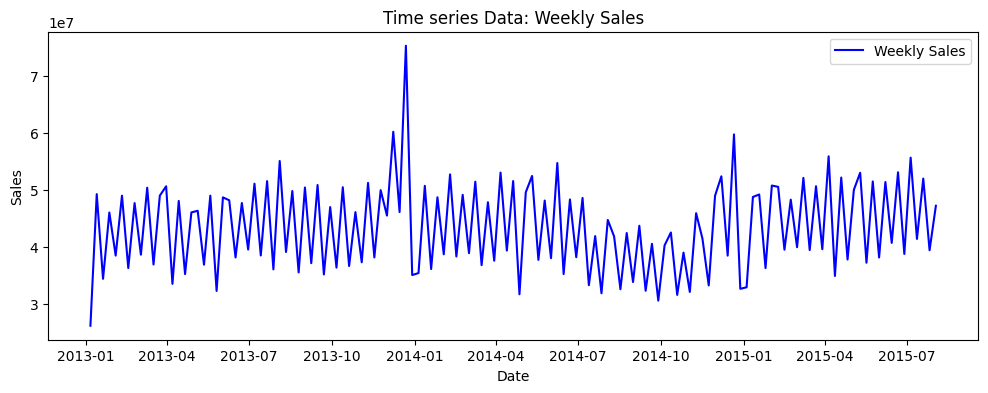

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(y, label='Weekly Sales', color='blue')  # Set the color to blue
plt.title('Time series Data: Weekly Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

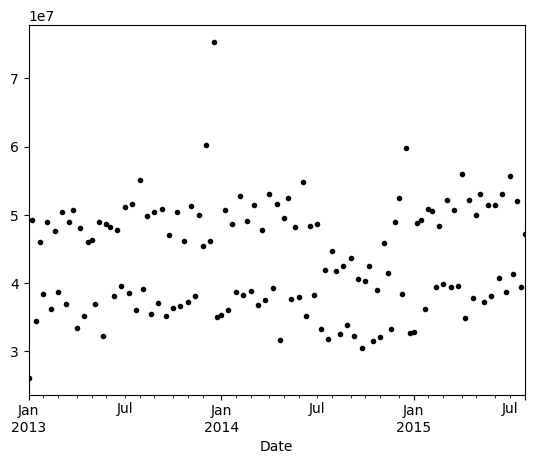

In [12]:
y.plot(style='k.')

<Axes: >

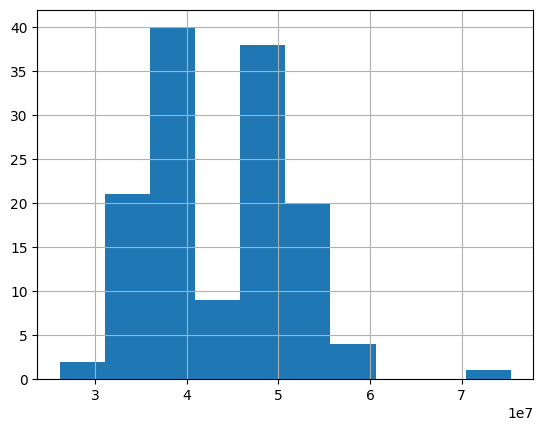

In [13]:
y.hist()

<Axes: ylabel='Density'>

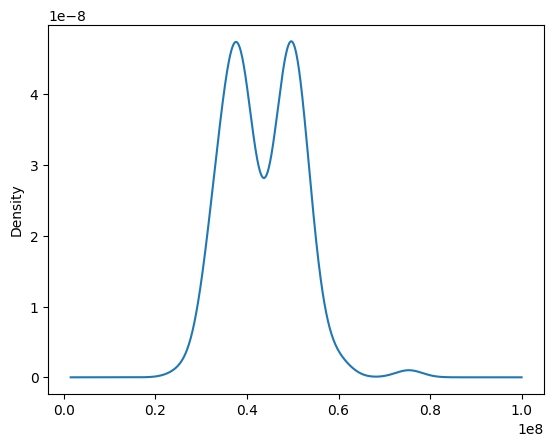

In [14]:
y.plot(kind='kde')

## Decomposing our time series

**One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present**

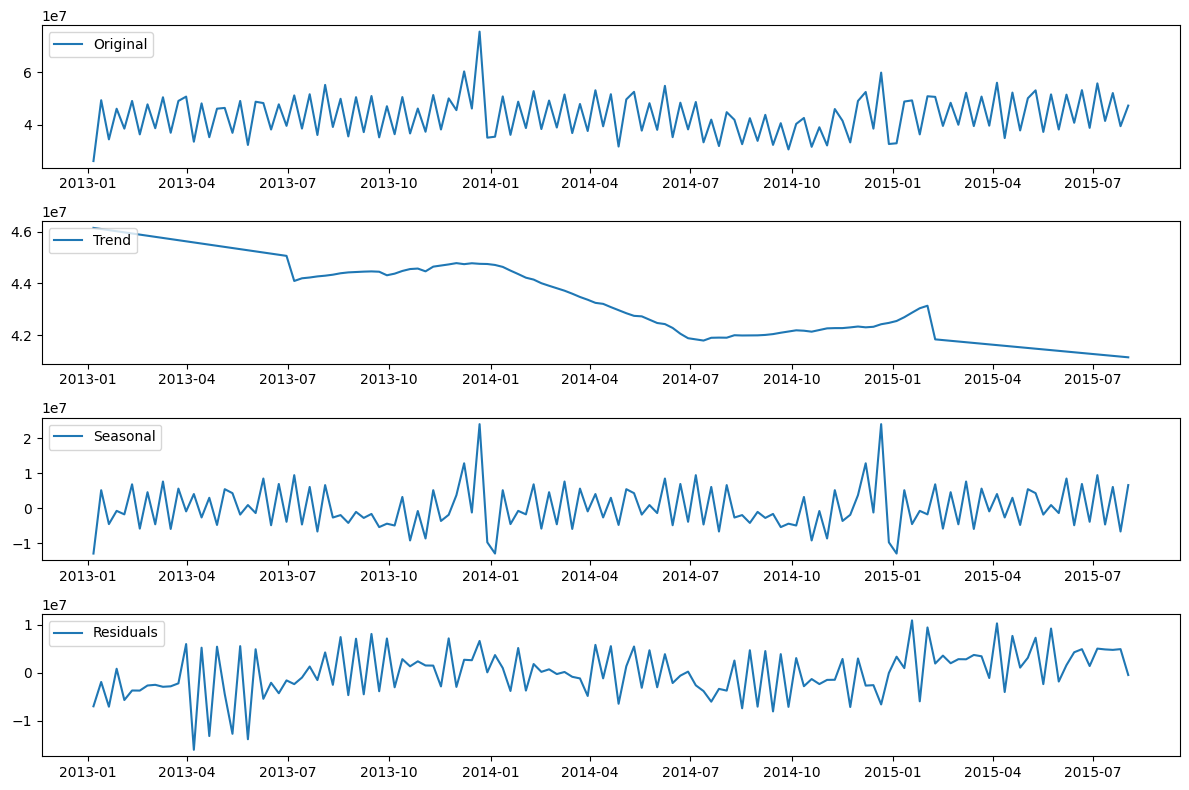

In [15]:
## Decompose the time series

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive', extrapolate_trend='freq')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(time_series['Sales'], label="Original")
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

**Observation:The curve is not appears to be a good fit for the seasonal structure in the dataset.**

# Stationarity

**Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different way.**


## Check whether your time Series Data is Stationary


### Autocorrelation and Partial autocorrelation plots:

**Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.**

**Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.**

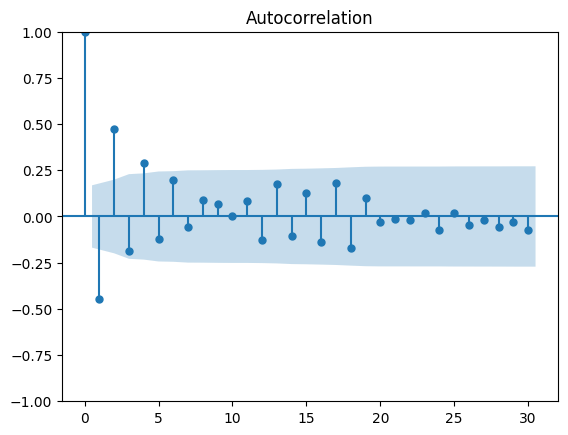

In [16]:
acf_plot = plot_acf(time_series['Sales'] , lags=30)

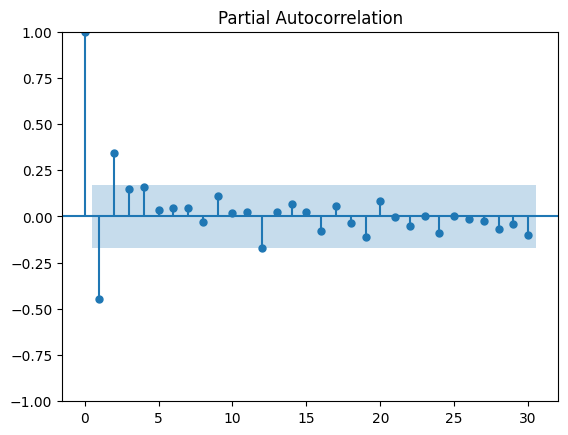

In [15]:
pacf_plot = plot_pacf(time_series['Sales'] , lags=30)

### Rolling means and standard deviation of our series
We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

In [17]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

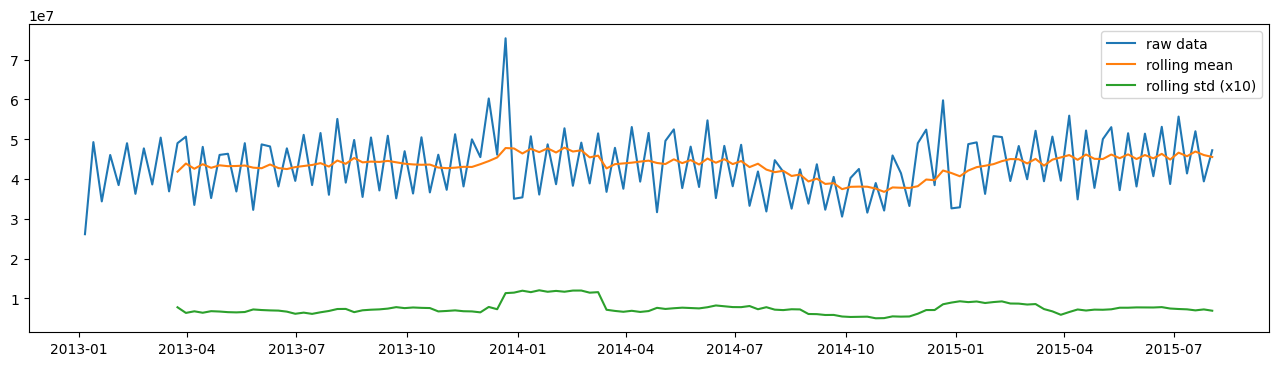

In [18]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

**We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year.**

## Augmented Dickey-Fuller test

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    if isinstance(timeseries, np.ndarray):
        timeseries = pd.Series(timeseries)
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [20]:
ADF_test(y, 'raw data')

 > Is the raw data stationary ?
Test statistic = -3.902
P-value = 0.002
Critical values :
	1%: -3.481281802271349 - The data is  stationary with 99% confidence
	5%: -2.883867891664528 - The data is  stationary with 95% confidence
	10%: -2.5786771965503177 - The data is  stationary with 90% confidence


## KPSS Test

In [21]:
def perform_kpss_test(time_series, **kw):
    statistic, p_value, lags, critical_values = kpss(time_series, **kw)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'P-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= 0.05:
        print("Result: Series is not stationary (reject the null hypothesis)")
    else:
        print("Result: Series is stationary (fail to reject the null hypothesis)")

# Perform the KPSS test
perform_kpss_test(time_series['Sales'], regression="ct", nlags="auto")

KPSS Statistic: 0.15819568783458654
P-value: 0.03983692680451121
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216
Result: Series is not stationary (reject the null hypothesis)


## Detrending
removes underlying trend of the time series

 > Is the de-trended data stationary ?
Test statistic = -7.829
P-value = 0.000
Critical values :
	1%: -3.4851223522012855 - The data is  stationary with 99% confidence
	5%: -2.88553750045158 - The data is  stationary with 95% confidence
	10%: -2.5795685622144586 - The data is  stationary with 90% confidence


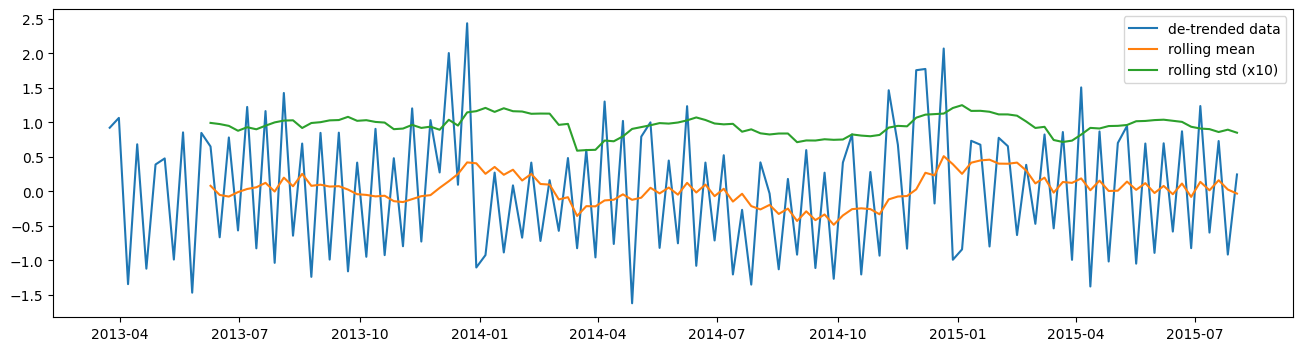

In [22]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

# Differencing
removes underlying seasonal or cyclical pattern of the time series

 > Is the differenced data stationary ?
Test statistic = -8.342
P-value = 0.000
Critical values :
	1%: -3.482087964046026 - The data is  stationary with 99% confidence
	5%: -2.8842185101614626 - The data is  stationary with 95% confidence
	10%: -2.578864381347275 - The data is  stationary with 90% confidence


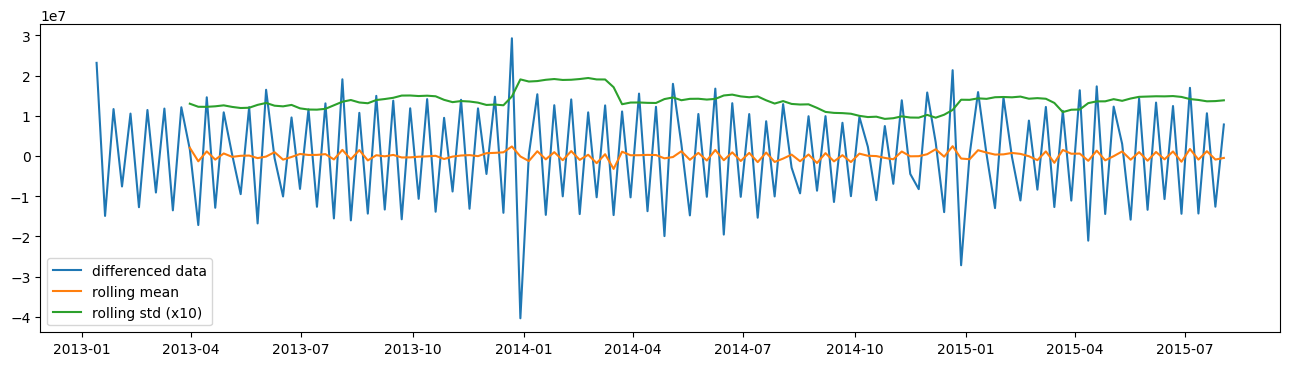

In [23]:
# Differencing
first_diff = time_series['Sales'].diff()
test_stationarity(first_diff,'differenced data')
ADF_test(first_diff,'differenced data')

# Set the y_to_train, y_to_test, and the length of predict units

In [24]:
y_to_train = y[:'2015-01-25'] # dataset to train
y_to_val = y['2015-02-01':] # last X months for test  
predict_date = len(y) - len(y[:'2015-02-01']) # the number of data points for the test set

In [25]:
print(y.index)

DatetimeIndex(['2013-01-06', '2013-01-13', '2013-01-20', '2013-01-27',
               '2013-02-03', '2013-02-10', '2013-02-17', '2013-02-24',
               '2013-03-03', '2013-03-10',
               ...
               '2015-05-31', '2015-06-07', '2015-06-14', '2015-06-21',
               '2015-06-28', '2015-07-05', '2015-07-12', '2015-07-19',
               '2015-07-26', '2015-08-02'],
              dtype='datetime64[ns]', name='Date', length=135, freq='W-SUN')


# Different Time Series Prediction Models

# 1.SARIMA

## Plotting PACF & ACF of first differencing
To identify initial p, seasonal P (from PACF) & q, seassonal q (from ACF)

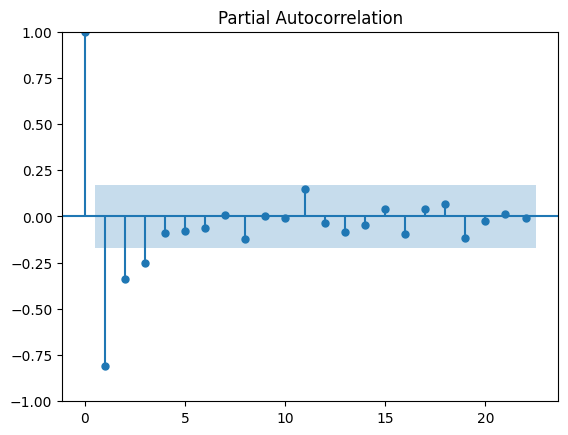

In [26]:
pacf_plot = plot_pacf(time_series['Sales'].diff()[1:])

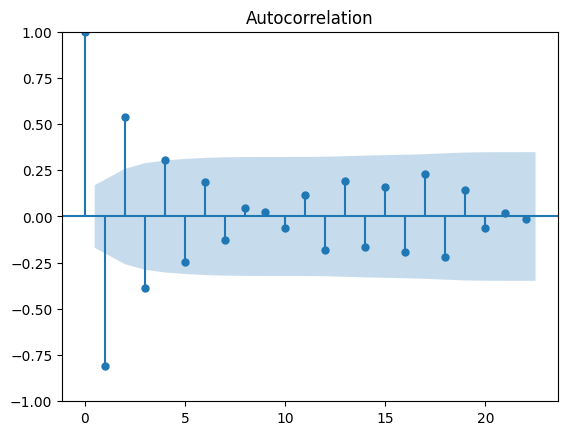

In [27]:
acf_plot = plot_acf(time_series['Sales'].diff()[1:])

## Grid search for the combination of (p.d,q) & (P,D,Q)m

In [49]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [50]:
sarima_grid_search(y,12)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:3759.4257749541075


In [51]:
order = (1,0,1)
seasonal_order = (0,1,1,12)
mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  135
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1902.476
Date:                            Tue, 06 Feb 2024   AIC                           3812.951
Time:                                    00:28:21   BIC                           3823.717
Sample:                                01-06-2013   HQIC                          3817.317
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8408      0.109     -7.704      0.000      -1.055      -0.627
ma.L1          0.5181      0.174   

## Model fitting, forecasting & evaluation

In [52]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()
    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6745      0.099     -6.782      0.000      -0.869      -0.480
ma.L1         -0.5226      0.199     -2.630      0.009      -0.912      -0.133
ma.S.L12      -0.7758      0.112     -6.918      0.000      -0.996      -0.556
sigma2        1.1e+14   4.57e-16   2.41e+29      0.000     1.1e+14     1.1e+14


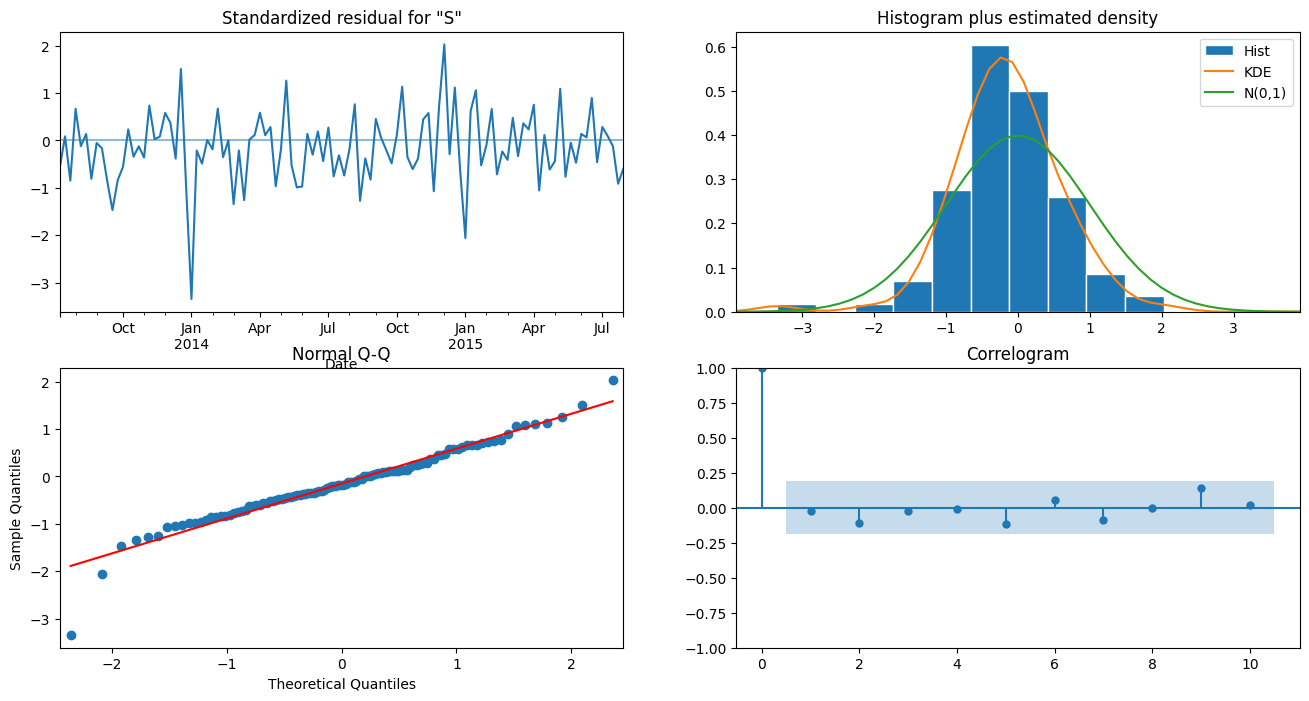

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 5812598.53


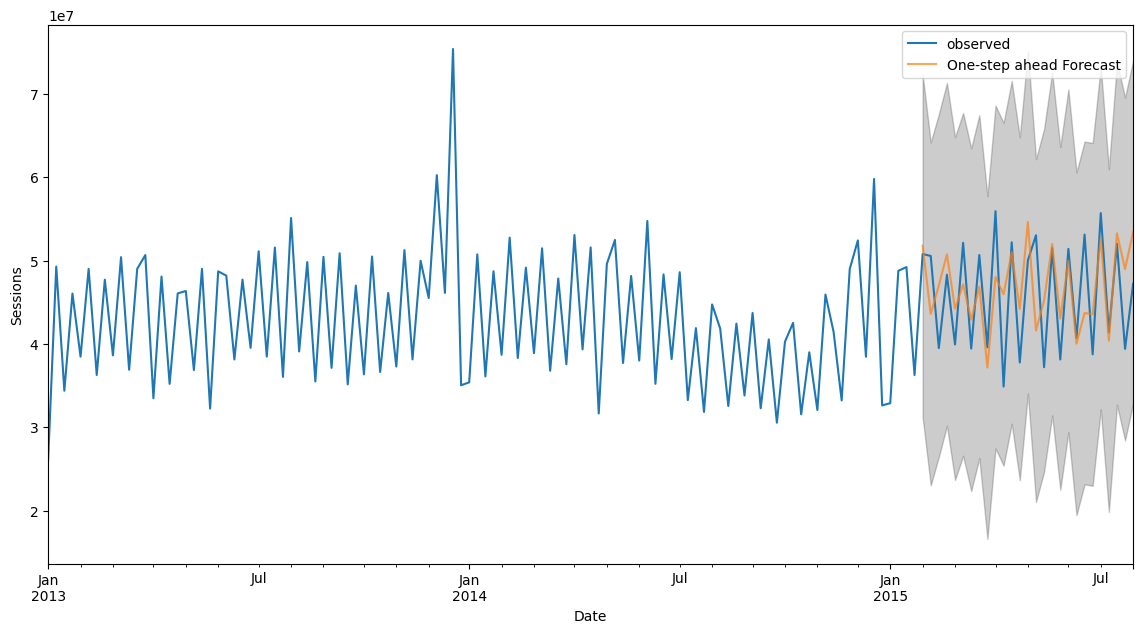

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 7821456.9


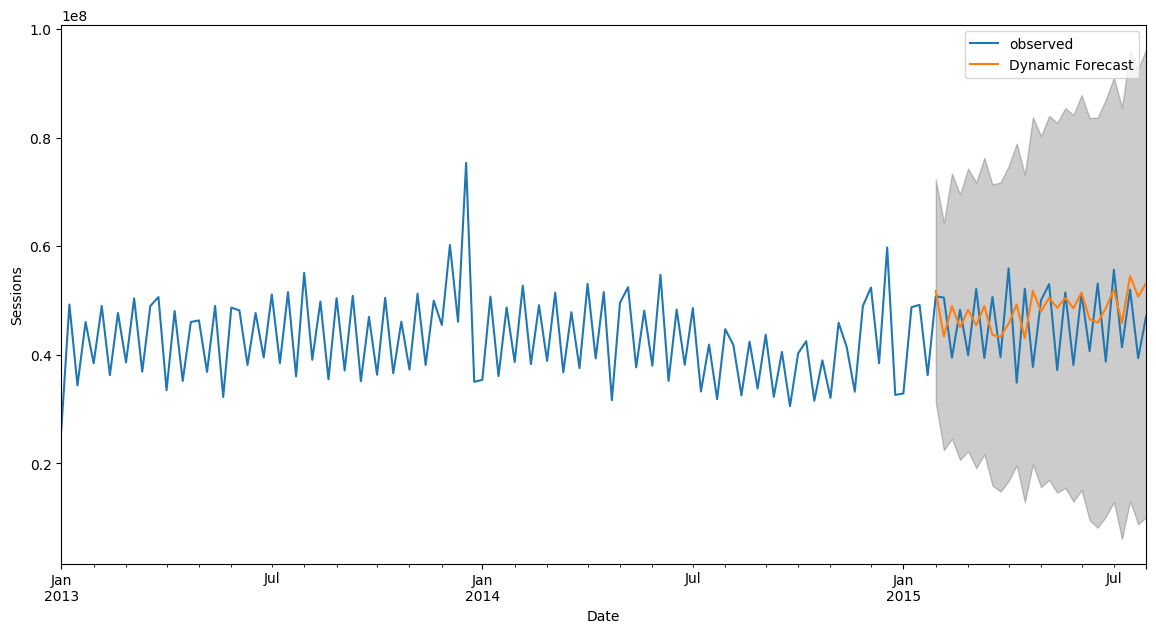

In [53]:
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 12),12,'2015-02-01',y_to_val)

# Making Predictions

In [54]:
def forecast(model,predict_steps,y): #predict_steps = 6 weeks ahead
    
    pred_uc = model.get_forecast(steps=predict_steps)

    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
    
    #print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)
    
    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

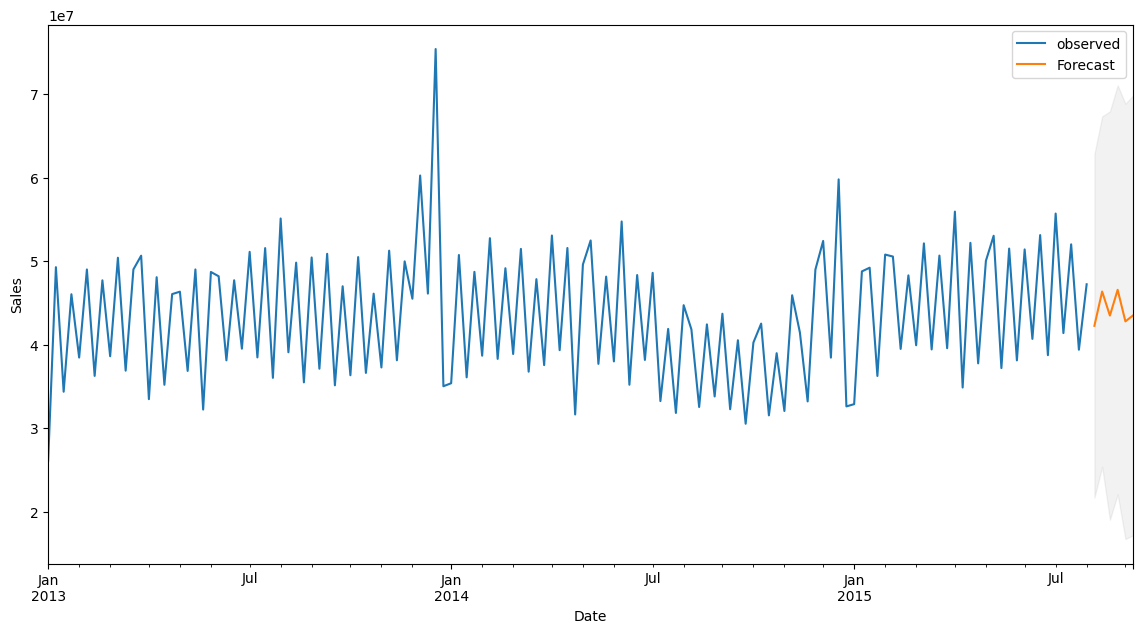

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2015-08-09,42260953.36591383,21700255.98987093,62821650.74195673
1,2015-08-16,46360244.69163192,25404259.91167046,67316229.47159338
2,2015-08-23,43486838.60588350,19060907.79309735,67912769.41866964
3,2015-08-30,46567464.93522473,22104105.90227466,71030823.96817479
4,2015-09-06,42791970.33400237,16758536.58859580,68825404.07940893
5,2015-09-13,43515456.30962826,17204566.71231588,69826345.90694065


In [55]:
final_table = forecast(model,6,y)
final_table.head(20)

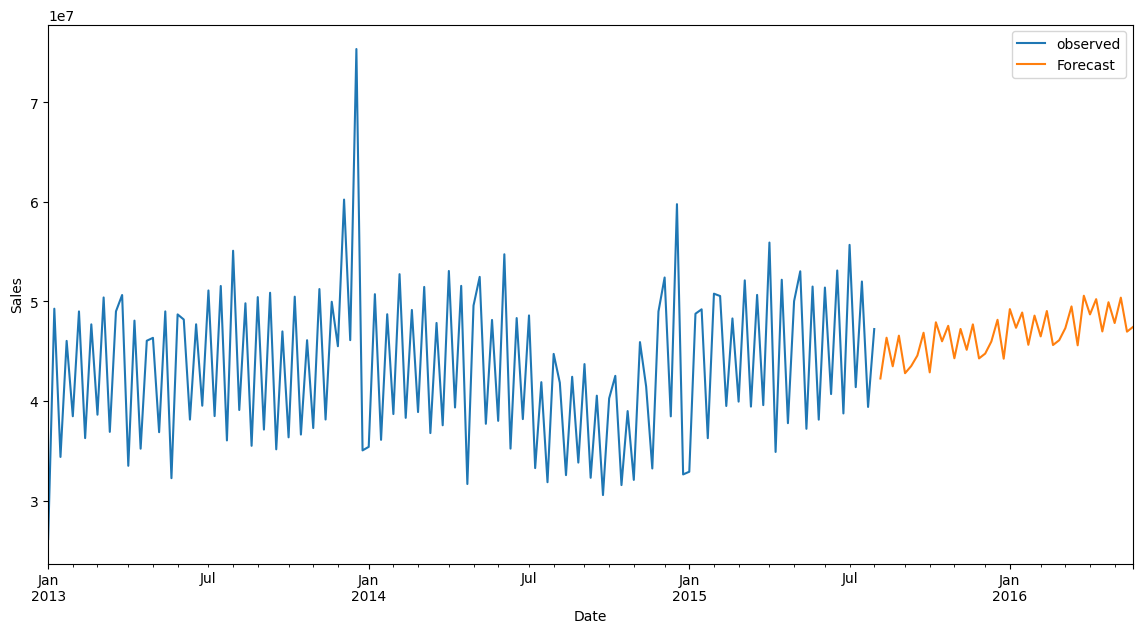

In [56]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=6*7)
ax = y.plot(label='observed', figsize=(14, 7))
#print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

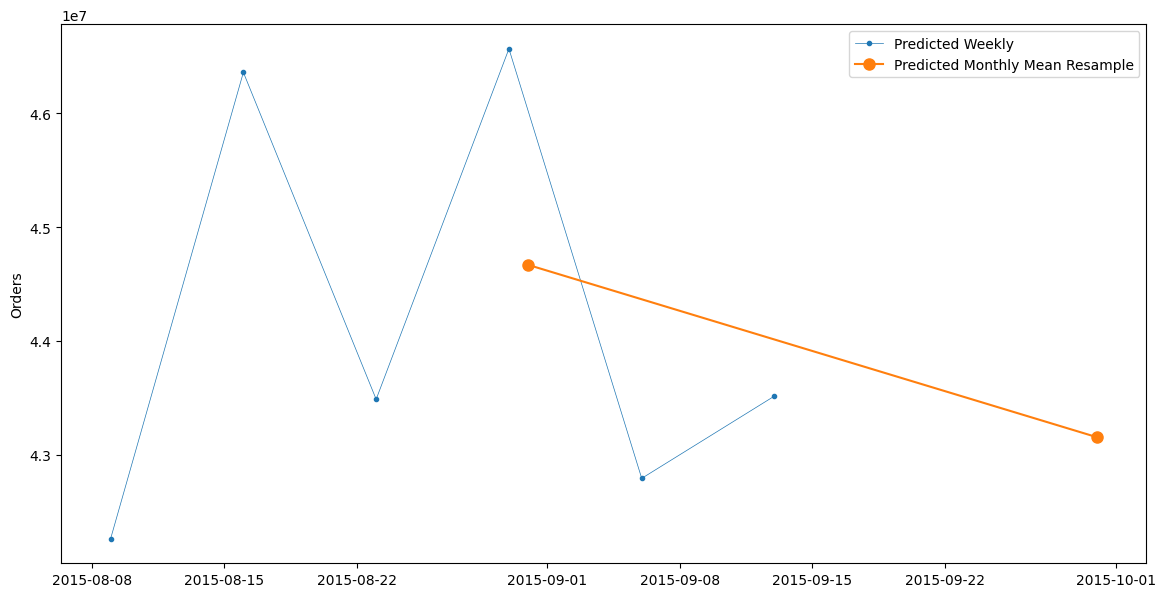

In [57]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();